In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os


In [7]:
# Dataset directory
train_dir = "C:\\Users\\VICTUS\\miniAI\\dataset\\train"
val_dir = "C:\\Users\\VICTUS\\miniAI\\dataset\\val"
test_dir = "C:\\Users\\VICTUS\\miniAI\\dataset\\test"

# Model parameters
num_classes = 7  # Specify the number of classes in your dataset
input_shape = (224, 224, 3)  # Input shape expected by DenseNet121

# Training parameters
batch_size = 8
epochs = 50
learning_rate = 0.001


In [8]:
# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 4200 images belonging to 7 classes.
Found 840 images belonging to 7 classes.


In [9]:
# Load pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Add GlobalAveragePooling2D layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add Dense layer for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(lr=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
 # Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model without early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,  # Train for exactly 50 epochs
    validation_data=val_generator,
    validation_steps=len(val_generator),
    batch_size=4,
    callbacks=[checkpoint, tensorboard]  # Keep other callbacks if needed
)


Epoch 1/50
525/525 [==============================] - ETA: 0s - loss: 1.5293 - accuracy: 0.4429
Epoch 1: val_loss improved from inf to 4.33263, saving model to best_model.h5
525/525 [==============================] - 112s 194ms/step - loss: 1.5293 - accuracy: 0.4429 - val_loss: 4.3326 - val_accuracy: 0.2238
Epoch 2/50
525/525 [==============================] - ETA: 0s - loss: 0.9891 - accuracy: 0.6595
Epoch 2: val_loss improved from 4.33263 to 2.50353, saving model to best_model.h5
525/525 [==============================] - 100s 191ms/step - loss: 0.9891 - accuracy: 0.6595 - val_loss: 2.5035 - val_accuracy: 0.4333
Epoch 3/50
525/525 [==============================] - ETA: 0s - loss: 0.8637 - accuracy: 0.7052
Epoch 3: val_loss did not improve from 2.50353
525/525 [==============================] - 99s 188ms/step - loss: 0.8637 - accuracy: 0.7052 - val_loss: 2.7184 - val_accuracy: 0.4071
Epoch 4/50
525/525 [==============================] - ETA: 0s - loss: 0.7615 - accuracy: 0.7474
Epoch

Found 420 images belonging to 7 classes.
53/53 [==============================] - 4s 49ms/step


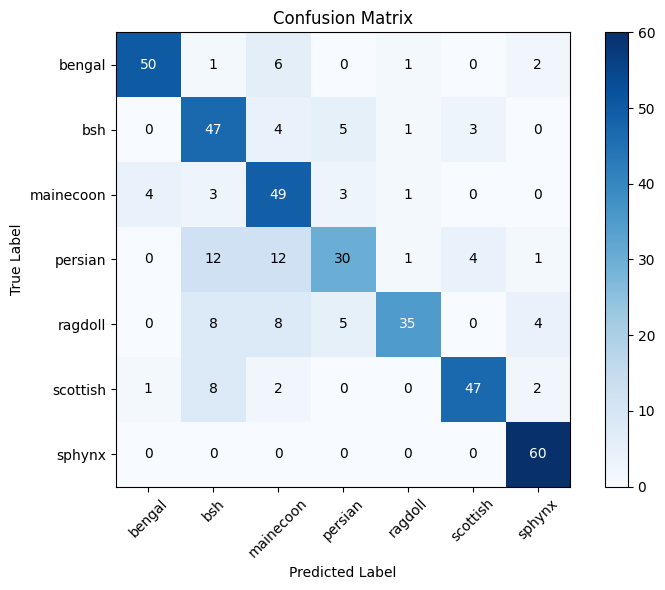

              precision    recall  f1-score   support

      bengal       0.91      0.83      0.87        60
         bsh       0.59      0.78      0.68        60
   mainecoon       0.60      0.82      0.70        60
     persian       0.70      0.50      0.58        60
     ragdoll       0.90      0.58      0.71        60
    scottish       0.87      0.78      0.82        60
      sphynx       0.87      1.00      0.93        60

    accuracy                           0.76       420
   macro avg       0.78      0.76      0.76       420
weighted avg       0.78      0.76      0.76       420



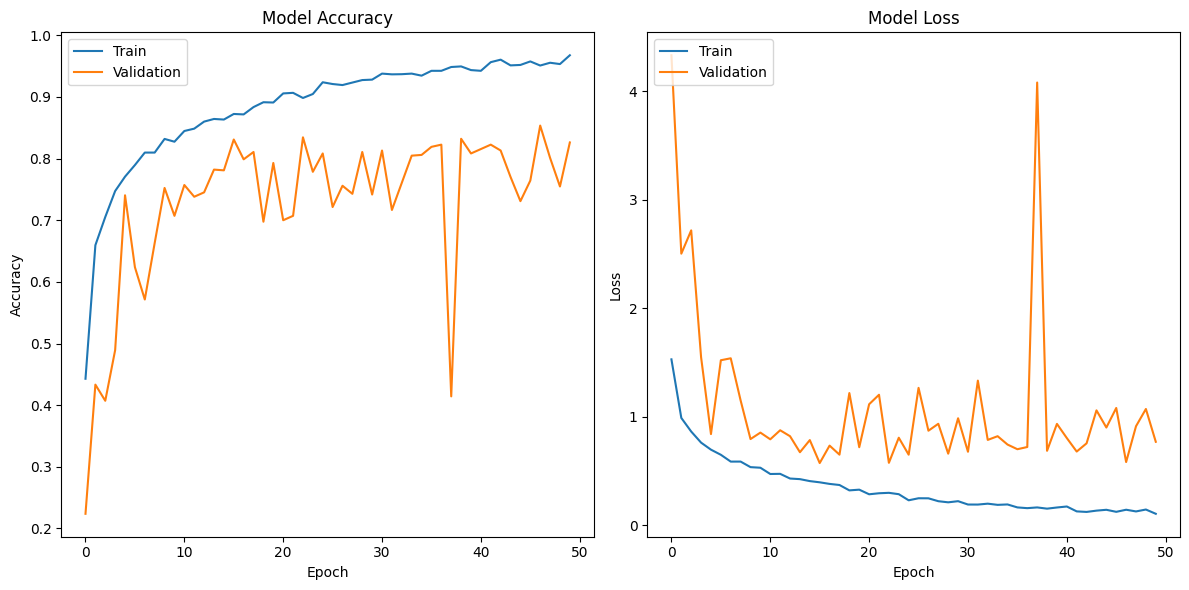

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load best model
model = tf.keras.models.load_model('best_model.h5')

# Evaluate on test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix with numerical annotations
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [12]:
# Assuming `history` object is available after training
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')


Final Training Loss: 0.1054
Final Validation Loss: 0.7692


In [13]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


53/53 [==============================] - 5s 48ms/step - loss: 0.8334 - accuracy: 0.7571
Test Loss: 0.8334
Test Accuracy: 0.7571


In [14]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, MobileNetV3Small, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import pandas as pd


In [15]:
# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\VICTUS\\miniAI\\dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators without additional preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 4200 images belonging to 7 classes.
Found 840 images belonging to 7 classes.
Found 420 images belonging to 7 classes.


In [16]:
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'model' is your trained DenseNet121 model loaded from 'best_model.h5'
model = tf.keras.models.load_model('best_model.h5')

# Assuming 'test_generator' is your test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'C:\\Users\\VICTUS\\miniAI\\dataset\\test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate on test set
start_time = time.time()
loss, accuracy = model.evaluate(test_generator)
end_time = time.time()
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"\nAccuracy: {accuracy:.4f}")

# Classification Report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Training time
training_time = end_time - start_time
print(f"\nTraining Time: {training_time:.2f} seconds")


Found 420 images belonging to 7 classes.
14/14 [==============================] - 4s 169ms/step - loss: 0.8334 - accuracy: 0.7548
Test Loss: 0.8334
Test Accuracy: 0.7548
14/14 [==============================] - 4s 179ms/step

Accuracy: 0.7548

Classification Report:
              precision    recall  f1-score   support

      bengal       0.91      0.83      0.87        60
         bsh       0.59      0.78      0.68        60
   mainecoon       0.60      0.82      0.70        60
     persian       0.69      0.48      0.57        60
     ragdoll       0.90      0.58      0.71        60
    scottish       0.87      0.78      0.82        60
      sphynx       0.86      1.00      0.92        60

    accuracy                           0.75       420
   macro avg       0.77      0.75      0.75       420
weighted avg       0.77      0.75      0.75       420


Training Time: 4.47 seconds


Found 4200 images belonging to 7 classes.
Found 840 images belonging to 7 classes.
Found 420 images belonging to 7 classes.
Epoch 1/50
132/132 [==============================] - ETA: 0s - loss: 3.8899 - accuracy: 0.2212
Epoch 1: val_accuracy improved from -inf to 0.26786, saving model to best_densenet121_model.h5
132/132 [==============================] - 55s 372ms/step - loss: 3.8899 - accuracy: 0.2212 - val_loss: 1.8232 - val_accuracy: 0.2679
Epoch 2/50
132/132 [==============================] - ETA: 0s - loss: 1.8207 - accuracy: 0.2850
Epoch 2: val_accuracy improved from 0.26786 to 0.29405, saving model to best_densenet121_model.h5
132/132 [==============================] - 51s 382ms/step - loss: 1.8207 - accuracy: 0.2850 - val_loss: 1.7806 - val_accuracy: 0.2940
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 1.7918 - accuracy: 0.2867
Epoch 3: val_accuracy improved from 0.29405 to 0.32381, saving model to best_densenet121_model.h5
132/132 [====================

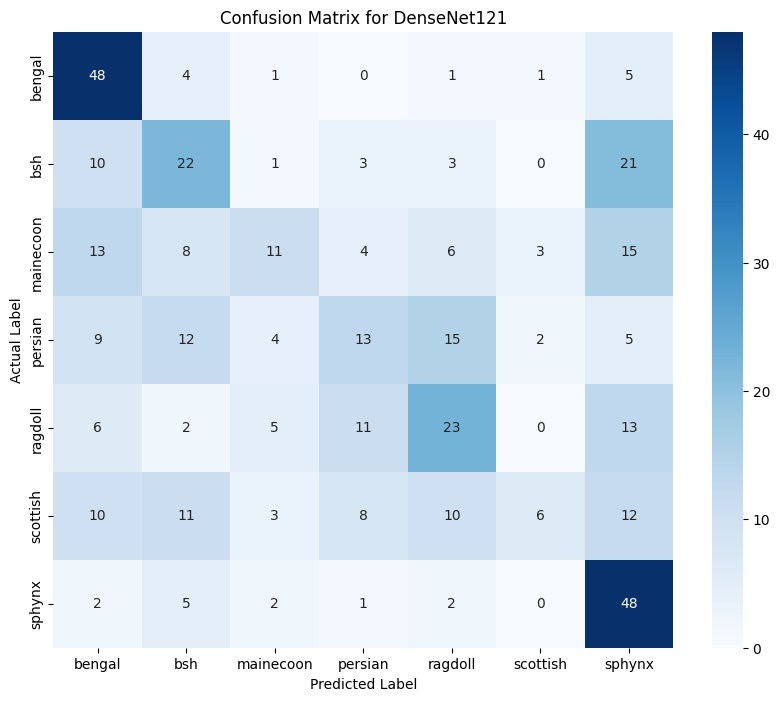

Classification Report for DenseNet121
              precision    recall  f1-score   support

      bengal       0.49      0.80      0.61        60
         bsh       0.34      0.37      0.35        60
   mainecoon       0.41      0.18      0.25        60
     persian       0.33      0.22      0.26        60
     ragdoll       0.38      0.38      0.38        60
    scottish       0.50      0.10      0.17        60
      sphynx       0.40      0.80      0.54        60

    accuracy                           0.41       420
   macro avg       0.41      0.41      0.37       420
weighted avg       0.41      0.41      0.37       420



In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
import time

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\VICTUS\\miniAI\\dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_densenet121_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_densenet121', histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard, early_stopping]
)
training_time = time.time() - start_time

# Load the best model
model = tf.keras.models.load_model('best_densenet121_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")
print(f"Training Time: {training_time} seconds")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for DenseNet121')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for DenseNet121')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))


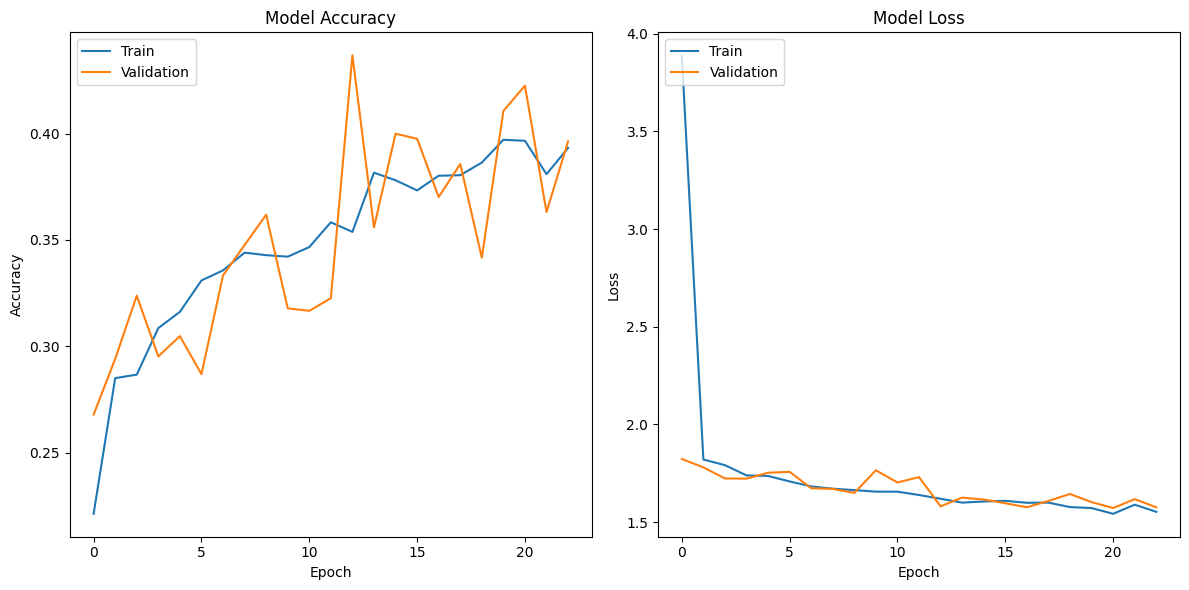

In [18]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [19]:
import tensorflow as tf
from tensorflow.keras.backend import clear_session

clear_session()  # Clears the session to free memory


In [20]:
import os
from PIL import Image

problematic_files = []
for root, _, files in os.walk("C:\\Users\\VICTUS\\miniAI\\dataset"):
    for file in files:
        try:
            img_path = os.path.join(root, file)
            img = Image.open(img_path)
            img.verify()  # Check for corrupted files
        except Exception as e:
            print(f"Problem with file: {img_path}, Error: {e}")
            problematic_files.append(img_path)


In [21]:
for root, _, files in os.walk("C:\\Users\\VICTUS\\miniAI\\dataset"):
    for file in files:
        try:
            img_path = os.path.join(root, file)
            img = Image.open(img_path)
            img = img.resize((128, 128))  # Resize or preprocess
        except Exception as e:
            print(f"Invalid file detected: {img_path}, Error: {e}")


In [22]:
import os

# Path to the main dataset folder
dataset_path = "C:\\Users\\VICTUS\\miniAI\\dataset"  # Replace with the actual path

# Count the number of files in each class folder
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls)))
                for cls in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cls))}

# Print class counts
print("Class Counts:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


Class Counts:
test: 7
train: 7
val: 7
